### HOD: Stellar Mass Function comparison with SDSS DR3 (v.0.9)


This is a semplified example that shows how to:
1. Calculate HOD Catalogue volume based on cosmology.

2. Compare the Stellar Mass Function obtained from a HOD populated galaxy catalogue with the stellar mass function obtained by the SDSS DR3 data (Panter et al. 2007). The input galaxy catalogue is a sub-sample obtained with Moster10 model (Moster et al. 2010) with a mass threshold of 1E10. It's possible to use the Zheavi11 (Zehavi et al. 2011) or Zheavi05 (Zehavi et al. 2005) models too.

3. Plot the galaxy distribution of the most populated halo in the HOD catalogue.

Be sure to compare data with the same units, in this case: [$Mpc^{-3}$ $h^{-1}$] and [$M_{\odot}$ $h^{-1}]$ for y-axis and x-axis respectively.

In [22]:
import CosmoBolognaLib as cbl
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

SMF function from SDSS DR3 data (Panter et al. 2007).

In [23]:
def stellarMassFunction(xValue, Phi0=2.2E-3, M0= 1.005E11, alpha=-1.222, hFactor=1.0):
    '''
        Returns the Schechter function based on input data
        Default: returns the SDSS DR3 curve
        scalingFactor is a parameter used to correct for the units:
        Standard units are: h^5 Mpc^-3 Msun^-1, if M0=[Msun h^-2] and Phi0=[h^3 Mpc^-3]
    '''
    
    return   Phi0 * np.log(10) * np.exp(-xValue / M0) * (xValue / M0)**(alpha + 1) * hFactor

Set cosmology parameters. Planck values are used by default.

In [24]:
cosm = cbl.Cosmology()
cosm.set_OmegaB(0.049)
cosm.set_OmegaM(0.319)
cosm.set_OmegaDE(0.681)
cosm.set_sigma8(0.83)
cosm.set_hh(0.67)

print(f'Omega Barions: {0.049}')
print(f'Omega Matter: {0.319}')
print(f'Omega Dark Energy: {0.681}')
print(f'sigma8: {0.83}')
print(f'h: {0.67}')

Omega Barions: 0.049
Omega Matter: 0.319
Omega Dark Energy: 0.681
sigma8: 0.83
h: 0.67


Calculate the catalogue Volume in $[Mpc/h]^3$ and plot the galaxies distribution. The catalogue volume is 1/8 of sphere.


Catalogue Volume: 3.677700e+07 [Mpc\h]^3


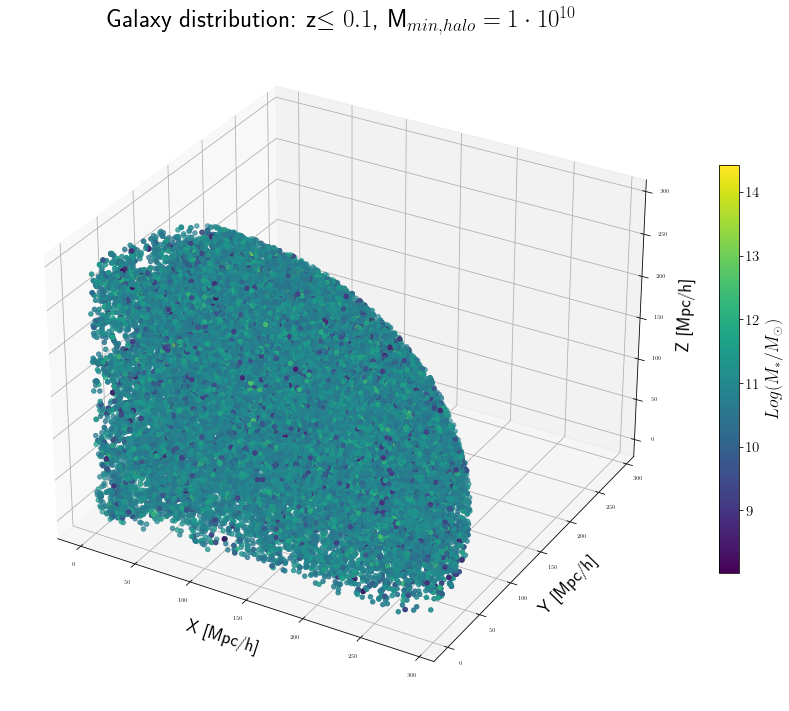

In [25]:
maximumRedshift = 0.07
totalVolume = 4./3. * np.pi * cosm.D_C(maximumRedshift)**3

print("================================================================")
print ("Catalogue Volume: " + str("{:.6e}".format(totalVolume)), "[Mpc\h]^3")
print("================================================================")

galaxyCataloguePathName = '../output/Galaxies_1e8_Moster_test.dat'
myDF = pd.read_csv(galaxyCataloguePathName, index_col=False, header=0, sep="\t")

# Galaxies plot
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111, projection='3d')
sctPlot = ax.scatter(myDF['(2)X [Mpc/h]'], myDF['(3)Y [Mpc/h]'], myDF['(4)Z [Mpc/h]'], c=np.log10(myDF['(6)M_infall [M_sun/h]']))
cbar = fig.colorbar(sctPlot, shrink=0.5, aspect=20, label="$Log(M_*/M_{\odot}/h)$")
cbar.set_label('$Log(M_*/M_{\odot})$', fontsize=18)

ax.set_title('Galaxy distribution: z$\leq 0.1$, M$_{min,halo}=1 \cdot 10^{10}$', fontsize=25)
ax.set_xlabel('X [Mpc/h]', fontsize=18)
ax.set_ylabel('Y [Mpc/h]',fontsize=18)
ax.set_zlabel('Z [Mpc/h]', fontsize=18)
ax.xaxis.labelpad=7
ax.yaxis.labelpad=7
ax.zaxis.labelpad=7
ax.tick_params(labelsize=5)
cbar.ax.tick_params(labelsize=15)
plt.show()

Generate the catalogue. The required variables are:
1. GalaxyTag: 0=Central galaxy, 1=Satellite galaxy
2. Comoving Coordinates in 3D space: X,Y,Z
3. Infall mass [ $M_{\odot}h^{-1}$ ] 

In [36]:
catalogueCbl = cbl.Catalogue(
        cbl.ObjectType__Galaxy_, # Type of objects
        cbl.CoordinateType__comoving_, # Type of coordinates
        cbl.VarCast([cbl.Var__GalaxyTag_, cbl.Var__X_, cbl.Var__Y_, cbl.Var__Z_, cbl.Var__Mass_]), # variables vector
        [1,2,3,4,7], # Columns to read in file
        ["../output/Galaxies_1e8_Moster_test.dat"], # catalogue name
        1, # Skip Rows
        1.0, #Subsamples
        1., # Factor
        cosm, # cosmology
        cbl.CoordinateUnits__radians_, # coord units
        '\t', # delimiter
        3213 # Seed
    )

print("====================== CATALOGUE: ==============================")
print("Catalogue generated: Galaxies_1e8_Moster_test.dat", )
print("Min stellar mass: " + str("{:.3e}".format(catalogueCbl.Min(cbl.Var__Mass_))) + 
" --  Max stellar mass : " + str("{:.3e}".format(catalogueCbl.Max(cbl.Var__Mass_))))


====================== CATALOGUE: ==============================
Catalogue generated: Galaxies_1e8_Moster_test.dat
Min stellar mass: 7.000e+07 --  Max stellar mass : 6.740e+11


Generate the file **CountsInCatalogue.dat** with number counts per bin of mass and erorr on counts.

In [52]:
Nbins = 20
MinMass = 1.e8
MaxMass = 1.e14
binCenter = 0.5

NC = cbl.NumberCounts1D_Mass(catalogueCbl, Nbins, MinMass, MaxMass, binCenter, cbl.HistogramType__dn_dlogV_, totalVolume)
NC.measure(cbl.ErrorType__Poisson_)
NC.write("../output/", "CountsInCatalogue.dat")

binsM, SMF, errSMF = NC.dataset().xx(), NC.dataset().data(), NC.dataset().error()

# Check units: the results should be in [Mpc^-3 h^-1] and [Msun/h] for y and x respectively
SMF = np.array(SMF) / cosm.hh()**7
#binsM = np.array(binsM) / cosm.hh()

Plot the Stellar Mass Functions and the residuals. If there are bins with 0 counts they will be removed.

The solid line is the SDSS DR3 curve and the dots represent the SFM obtained from the HOD method.

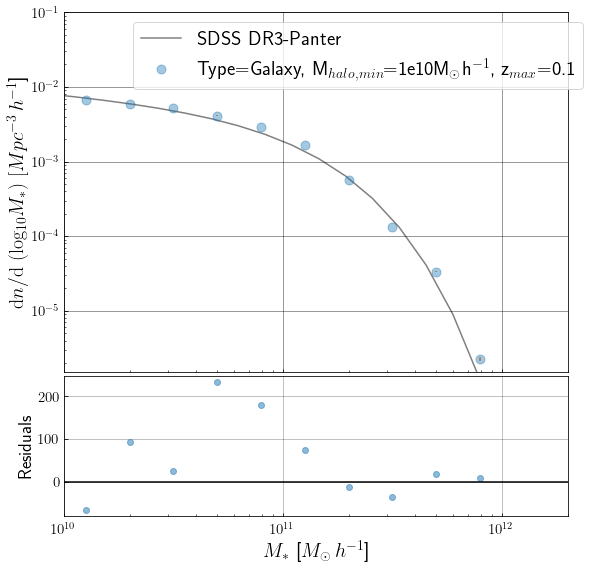

In [59]:
matplotlib.rcParams.update({"text.usetex":True})
fig = plt.figure(figsize=(7, 5))
ax0 = fig.add_axes([0., 0.4, 1., 1.])
ax1 = fig.add_axes([0., 0., 1., 0.39])

xValues = np.logspace(7, 13, 50)

# Add SDSS DR3 model curve to the plot:
SDSSDR3Panter = stellarMassFunction(xValues, hFactor=1.)
ax0.plot(xValues, SDSSDR3Panter, "-", markersize=10, color="black", markeredgecolor='black', markeredgewidth=2.,
         label="SDSS DR3-Panter", zorder=2, alpha=0.5)

# Plot the SMF with error bars:
ax0.plot(binsM, SMF, "o", markersize=9, label=r"Type=Galaxy, M$_{halo,min}$=1e10M$_{\odot}$h$^{-1}$, z$_{max}$=0.1", zorder=3, alpha=0.4)
ax0.errorbar(binsM, SMF, yerr=errSMF, fmt='none', elinewidth=1.7, zorder=0)

CatalogMassBins, CatalogSMFValue, CatalogError = np.loadtxt('../output/CountsInCatalogue.dat', unpack=True, usecols=[0,1,2])

# Removing bins with 0 counts:
mask = ~((CatalogSMFValue == 0.))
CatalogMassBins, CatalogSMFValue, CatalogError = CatalogMassBins[mask], CatalogSMFValue[mask], CatalogError[mask]

# Check units: for residual plot if needed to macth [Mpc^-3 h^-1] and [Msun/h] for y and x respectively
CatalogSMFValue = np.array(CatalogSMFValue) / cosm.hh()**7
#CatalogMassBins = np.array(CatalogMassBins) / cosm.hh()

residuals =  (CatalogSMFValue - stellarMassFunction(CatalogMassBins)) / CatalogError

ax1.plot(CatalogMassBins, residuals, ls='None', marker='o', markersize= 6, alpha=0.5)

# Plot Settings:
ax0.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize=20, numpoints=1)
ax0.set_ylabel("$\mathrm{d}n/\mathrm{d \ (log_{10}}M_*) \\ [\mathrm{Mpc}^{-3} \, h^{-1}$]", fontsize=20) # dn_dV actually
ax0.set_xlabel("$M_{*} \ [M_{\odot}\, h^{-1}]$", fontsize=20)
ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim([1.e8, 2.e12])
ax0.set_ylim([1.5e-6, 1.e-1])
ax0.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax0.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax0.set_xticklabels([]) # Removes x values on axis
ax0.grid(zorder=0, color='black', alpha=0.5)

ax1.axhline(y=0, color='k')
ax1.set_xscale('log')
ax1.set_xlabel("$M_*$ [$M_{\odot} \, h^{-1}$]", fontsize=20)
ax1.set_ylabel("Residuals", fontsize=18)
ax1.get_yaxis().set_tick_params(which='both', direction='in', labelsize=15)
ax1.get_xaxis().set_tick_params(which='both', direction='in', labelsize=15, pad=7)
ax1.grid(zorder=0, color='black', alpha=0.3)
ax1.set_xlim([1.e8, 2.e12])
#ax1.set_ylim([-150., 150.])
plt.show()

3D Plot of the most populated halo in catalogue colored by mass. 

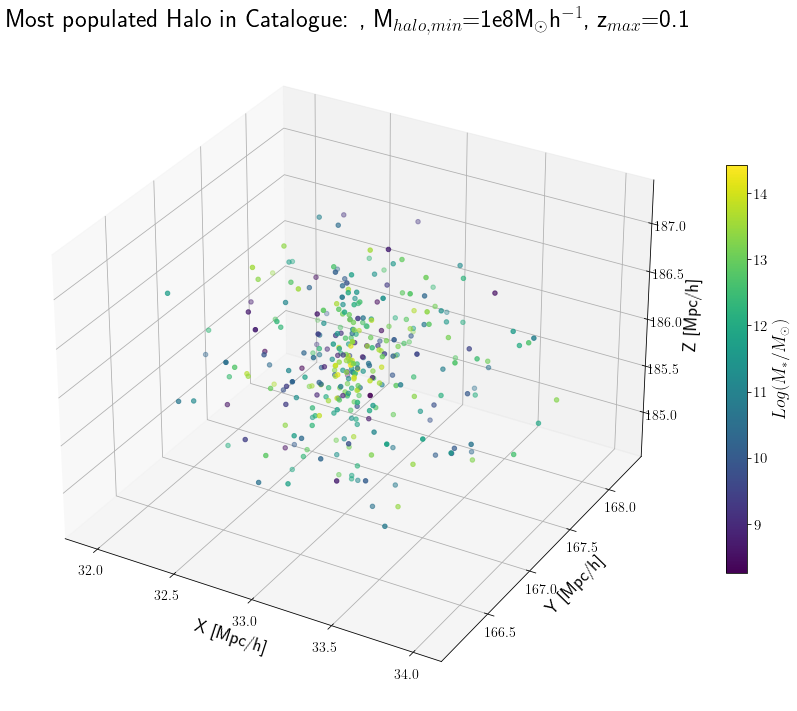

In [8]:
myDF = pd.read_csv('../output/Galaxies_1e8_Moster_test.dat', sep='\t', header=0, index_col=False)

ListOfCentrals = myDF.index[myDF['(1)galaxyTag'] == 0].tolist()
biggerHaloInSample = myDF.iloc[ListOfCentrals[-1]:, : ]

fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(111, projection='3d')
plt.title("Most populated Halo in Catalogue: , M$_{halo,min}$=1e8M$_{\odot}$h$^{-1}$, z$_{max}$=0.1", fontsize=25)
sctPlot = ax.scatter(biggerHaloInSample['(2)X [Mpc/h]'], biggerHaloInSample['(3)Y [Mpc/h]'], biggerHaloInSample['(4)Z [Mpc/h]'], c=np.log10(biggerHaloInSample['(6)M_infall [M_sun/h]']))
cbar = fig.colorbar(sctPlot, shrink=0.5, aspect=20, label="$Log(M_*/M_{\odot}/h)$")
cbar.set_label('$Log(M_*/M_{\odot})$', fontsize=18)

ax.set_xlabel('X [Mpc/h]', fontsize=18)
ax.set_ylabel('Y [Mpc/h]',fontsize=18)
ax.set_zlabel('Z [Mpc/h]', fontsize=18)
ax.xaxis.labelpad=7
ax.yaxis.labelpad=7
ax.zaxis.labelpad=7
ax.tick_params(labelsize=14)
cbar.ax.tick_params(labelsize=15)
plt.show()